In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random



In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)



AssertionError: Not enough GPU hardware devices available

In [3]:
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  0


In [4]:
# tf.debugging.set_log_device_placement(True)

In [5]:
#Size of our input images
# SIZE = 128        # It was this value at the beginning, but the image display was poor. 
SIZE = 224

# Setting the training and testing datasets 

ImageDataGenerator.flow_from_directory: Takes the path to a directory and generates batches of augmented data.

In [6]:
batch_size = 15
datagen = ImageDataGenerator(rescale=1./255) # Typically used for data augmentation. Here it is only rescaling the image pixels value to range 0 to 1 in decimals

train_generator = datagen.flow_from_directory(
    # "../../Images/BottleStoodUp_atNight/Positive/",
    "../../../BottleStoodUp_atNight/Positive/",
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'          # Class used for working with Autoencoders
    
    )

Found 179 images belonging to 1 classes.


In [7]:
validation_generator = datagen.flow_from_directory(
    # "../../Images/BottleStoodUp_atNight/Positive_val/",
    "../../../BottleStoodUp_atNight/Positive_val/",
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 30 images belonging to 1 classes.


In [8]:
anomaly_generator = datagen.flow_from_directory(
    # "../../Images/BottleStoodUp_atNight/Anomalies2.0/",
    "../../../BottleStoodUp_atNight/Anomalies2.0/",
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 6 images belonging to 1 classes.


In [9]:
test_set_generator = datagen.flow_from_directory(
    # "../../Images/BottleStoodUp_atNight/Evaluation/",
    "../../../BottleStoodUp_atNight/Evaluation/",
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 30 images belonging to 2 classes.


# Showing one sample of the training set images

Grabbing only one image of one batch of the training set.

In [10]:
images_in_batch = next(train_generator)[0]
print(type(images_in_batch))
print(len(images_in_batch))
print(tf.reduce_min(images_in_batch), tf.reduce_max(images_in_batch))

<class 'numpy.ndarray'>
15
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


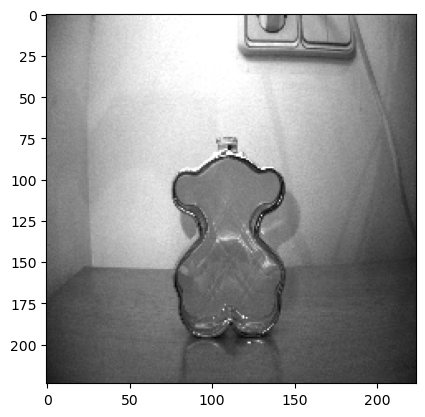

In [11]:
single_img = images_in_batch[0]
plt.imshow(single_img)

# Configuring the Autoencoder netwrok

In [12]:
#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 16)       0

In [13]:
# #Fit the model. 
# history = model.fit(
#         train_generator,
#         epochs=600,
#         validation_data=validation_generator,
#         shuffle = True)

In [14]:
# model_version = 'BottlesModel_TF_GPU'
# model.save(f"../../BottlesAnomalies_TFM/models/{model_version}")

Loading the model that was previously saved


In [15]:
model = keras.models.load_model('../models/BottlesModel_TF_GPU')
print(type(model))

<class 'keras.engine.sequential.Sequential'>


Get all batches generated by the datagen and pick a batch for prediction

In [16]:
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
# while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
while img_num < len(train_generator):        #I think this should be the correct while clause
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1
    
print("number of batches are: ", img_num)


number of batches are:  12


In [17]:
print(len(data_batch))

12


Predict on the first batch of images. Do also notice that the prediction is being carried out over the images we used for training.

In [18]:
print(data_batch[0].shape)
predicted = model.predict(data_batch[0])  
print(predicted.shape)

(15, 224, 224, 3)
1/1 [==============================] - 0s 405ms/step
(15, 224, 224, 3)


The above is 64 length because it corresponds to the 64 predicted images of a batch. Recall that the predictions are reconstructions of the input images, since we are working with the autoencoder network.

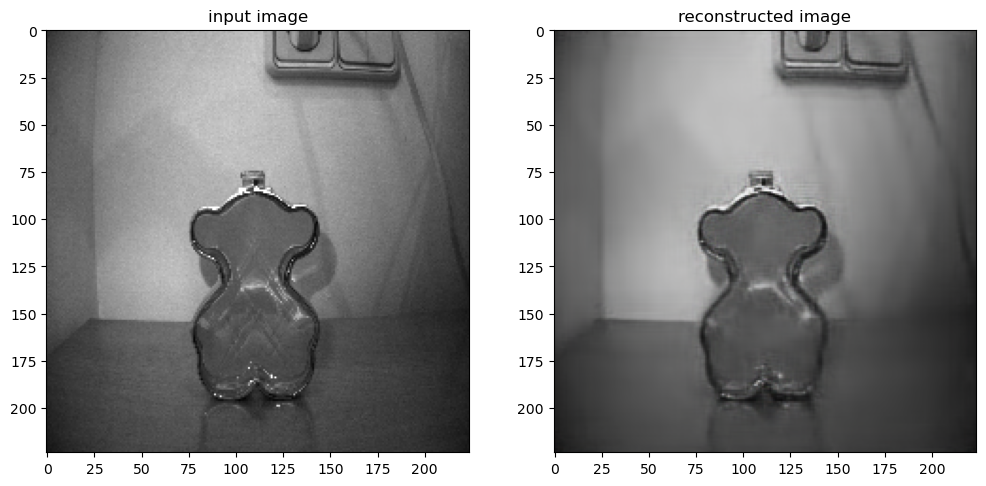

In [19]:
#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(predicted[image_number])
plt.show()

THe reconstructed image is way much better now.


# Quantifying the reconstruction error

Let us examine the reconstruction error of our validation data (good/normal images) and the anomaly images

In [20]:
validation_error = model.evaluate_generator(validation_generator)
print("Recon. error for the validation (normal) data is: ", validation_error)

C:\Users\Alex\AppData\Local\Temp\ipykernel_15804\2207300971.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  validation_error = model.evaluate_generator(validation_generator)


Recon. error for the validation (normal) data is:  [0.001003445591777563, 0.001003445591777563]


Here above we see a vector with two components which happen to be the same between them. This is because in the model, when we define the outputs, the loss function type and the metric are the same parameter, the mse (mean square error).

This reconstruction error above should be very low, since the validation generator is full of normal images (good images)

Whereas the reconstruction error here below, for the "anomaly_generator" should be higher, since this dataset is comprised of full anomaly images.

In [21]:
anomaly_error = model.evaluate_generator(anomaly_generator)
print("Recon. error for the anomaly data is: ", anomaly_error)

C:\Users\Alex\AppData\Local\Temp\ipykernel_15804\4089772597.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  anomaly_error = model.evaluate_generator(anomaly_generator)


Recon. error for the anomaly data is:  [0.0009528631926514208, 0.0009528631926514208]


See that this error is slightly higher than the error in the validation dataset. This is good, but the difference is not that significant and this could result in wrong anomaly detections. Let's see some detections.

SIDENOTE: Additionally, we can check the train generator error according to the "evaluate_generator()" function.

In [22]:
training_error = model.evaluate_generator(train_generator)
print("Recon. error for the training (non-anomaly) data is: ", training_error)

C:\Users\Alex\AppData\Local\Temp\ipykernel_15804\322309295.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  training_error = model.evaluate_generator(train_generator)


Recon. error for the training (non-anomaly) data is:  [0.0007283288286998868, 0.0007283287704922259]


See that the above value does not correspond with the below mean reconstruction error of the training set that will be computed. It should at least be close, I think. This is something to check.

# Computing the reconstruction error without using the "evaluate_generator()" function

The following function computes the reconstrution error per each batch of images. It does, for each of the batches:
- Initialize a vector for storing the reconstruction errors.
- A for loop that traverses all the images contained in a batch.
    - Take the one image of the batch.
    - Add a new size dimension to the image.
    - Make a prediction of the selected image with the model that was built.
    - Evaluate the performance of the prediction, i.e. compute the prediction error.
    - Append the reconstruction error into a list.
- Compute the mean and std deviation of the error.
 

In [23]:
def calc_recon_error(batch_images):   
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]):
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        # reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]    # The batch_size parameter for the moment can be supressed. Results were seen to be the same
        reconstruction_error = model.evaluate([reconstruction],[[img]])[0]
        recon_error_list.append(reconstruction_error)   
    return recon_error_list

In [24]:
total_rec_error = []
for i in range(len(train_generator)):        #I think this should be the correct while clause
    data = train_generator.next()
    total_rec_error.append(calc_recon_error(data[0]))
    
print("The list of rec. error contains ", len(total_rec_error), "batches of rec. errors")

1/1 [==============================] - 0s 44ms/step - loss: 0.0011 - mean_squared_error: 0.0011
The list of rec. error contains  12 batches of rec. errors


In [25]:
print(type(total_rec_error[0]))

<class 'list'>


In [26]:
total_rec_error_list = [item for sublist in total_rec_error for item in sublist]
print(len(total_rec_error_list))

179


In [27]:
na_average_recon_error = np.mean(np.array(total_rec_error_list))  
na_stdev_recon_error = np.std(np.array(total_rec_error_list)) 
min_prob = np.min(total_rec_error_list)
max_prob = np.max(total_rec_error_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_average_recon_error)
print("The standard deviation of the errors list is: ", na_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.001048191500289168
The standard deviation of the errors list is:  0.0001445831812835894
The min value of the errors list is:  0.0008668677764944732
The max value of the errors list is:  0.0014665813650935888


Compute the average and std dev. of recon. error for positive (anomalies) samples. 


In [28]:
anomaly_batch = anomaly_generator.next()

In [29]:
total_rec_error_anomalies = []
data = anomaly_generator.next()
total_rec_error_anomalies=calc_recon_error(data[0])
print(len(total_rec_error_anomalies))

1/1 [==============================] - 0s 51ms/step - loss: 0.0013 - mean_squared_error: 0.0013
6


In [32]:
a_average_recon_error = np.mean(np.array(total_rec_error_anomalies))  
a_stdev_recon_error = np.std(np.array(total_rec_error_anomalies)) 
min_prob = np.min(total_rec_error_anomalies)
max_prob = np.max(total_rec_error_anomalies)
print("THIS IS FOR THE ANOMALY IMAGES\n")
print("The average of the errors list is: ", a_average_recon_error)
print("The standard deviation of the errors list is: ", a_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE ANOMALY IMAGES

The average of the errors list is:  0.0013311573226625721
The standard deviation of the errors list is:  0.00018182861937971324
The min value of the errors list is:  0.0010720028076320887
The max value of the errors list is:  0.001664024661295116


Below, we can see the plot of the reconstruction error values, of the non-anomaly list (blue) and the anomaly list (red).

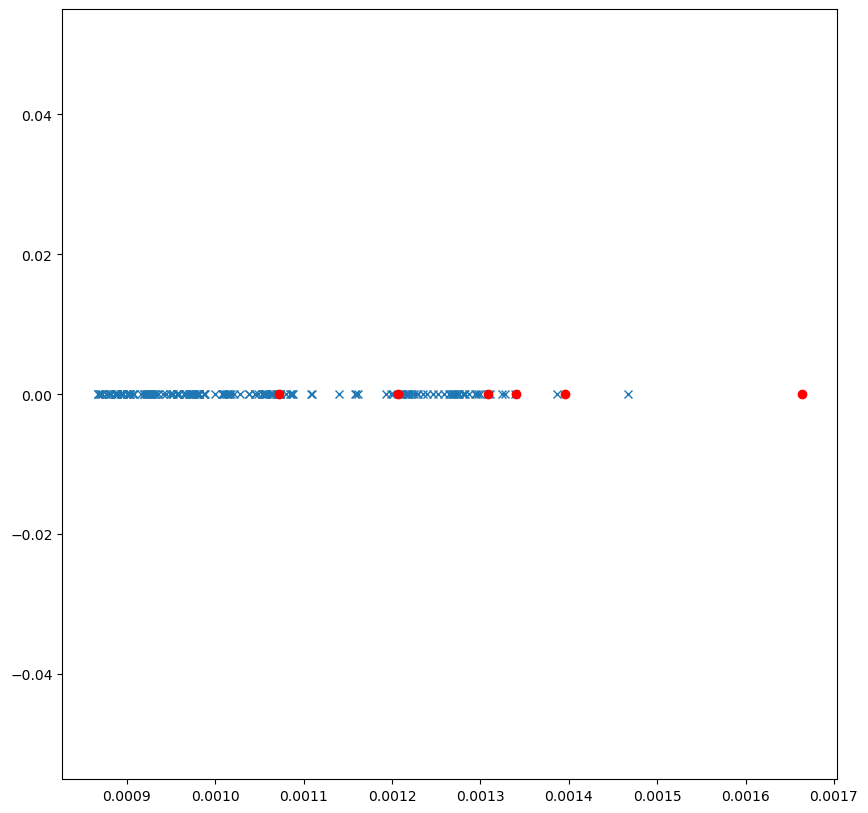

In [33]:
plt.figure(figsize=(10, 10))
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(total_rec_error_list, np.zeros_like(total_rec_error_list) + val, 'x')
plt.plot(total_rec_error_anomalies, np.zeros_like(total_rec_error_anomalies) + val, 'ro')
plt.show()

# Coding a function to check if an image contains anomalies

Based on the information shown above, we can set a threshold for discriminating good samples from anomalies ones. The threshold will be a simple one; it will only be based on a min reconstruction error value for them to be considered as non-anomaly images. 

The following function does:
- Sets the reconstruction error threshold.
- Opens the given image path.
- Resizes the image 
- Depending on the image size it adds a dimension to it. The image must be at the end of this of 3 dimensions in size.
- Converts the image pixel values to float numbers, ranging from 0 to 1. 
- Adds a fourth dimension to the image.
- Performs a prediction using the model and a given image.
- Computes the prediction error.
- Depending on the prediction error it prints the message to whether the image is an anomaly or not. 

In [34]:
#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
    reconstruction_error_threshold = 0.00133 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((SIZE,SIZE), Image.ANTIALIAS))
    image_shape = img.shape
    if(len(image_shape)==2):
        img = np.dstack((img, img, img))
    plt.imshow(img)
    img = img / 255.
    print(img.shape)
    img = img[np.newaxis, :,:,:]
    
    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if reconstruction_error > reconstruction_error_threshold:
        print("The image IS an anomaly") 
    else:
        print("The image is NOT an anomaly")

In [35]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
# anomaly_file_paths = glob.glob(r'D:\Alex2023\TFM\Images\BottleStoodUp_atNight\Anomalies2.0\Anomalies_samples\*')
# positive_file_paths = glob.glob(r'D:\Alex2023\TFM\Images\BottleStoodUp_atNight\Positive\Positive_samples\*')

# #  FOR work LAPTOP:
anomaly_file_paths = glob.glob(r'C:\Users\Alex\Documents\BottleStoodUp_atNight\Anomalies2.0\Anomalies_samples\*')
positive_file_paths = glob.glob(r'C:\Users\Alex\Documents\BottleStoodUp_atNight\Positive\Positive_samples\*')

# #  FOR UBUNTU LAPTOP:
# anomaly_file_paths = glob.glob(r'home\alexpc\Images\BottleStoodUp_atNight\Anomalies2.0\Anomalies_samples\*')
# positive_file_paths = glob.glob(r'home\alexpc\Images\BottleStoodUp_atNight\Positive\Positive_samples\*')

Checking the anomalies

(224, 224, 3)
1/1 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.0013

C:\Users\Alex\AppData\Local\Temp\ipykernel_15804\3813053636.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((SIZE,SIZE), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step - loss: 0.0013 - mean_squared_error: 0.0013
The image is NOT an anomaly
This image directory is:  C:\Users\Alex\Documents\BottleStoodUp_atNight\Anomalies2.0\Anomalies_samples\img4.jpg


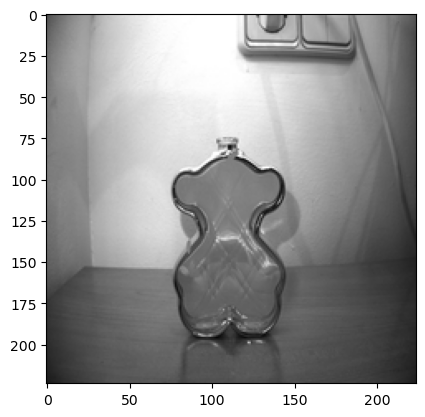

In [36]:
num=random.randint(0,len(anomaly_file_paths)-1)
check_anomaly(anomaly_file_paths[num])
print("This image directory is: ", anomaly_file_paths[num])

Checking the positive samples, these are NOT supposed to be anomalies.

(224, 224, 3)
1/1 [==============================] - 0s 49ms/step - loss: 8.4842e-04 - mean_squared_error: 8.4842e-04


C:\Users\Alex\AppData\Local\Temp\ipykernel_15804\3813053636.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((SIZE,SIZE), Image.ANTIALIAS))


The image is NOT an anomaly
This image directory is:  C:\Users\Alex\Documents\BottleStoodUp_atNight\Positive\Positive_samples\07-03-2023 - 22.58.40_10.bmp


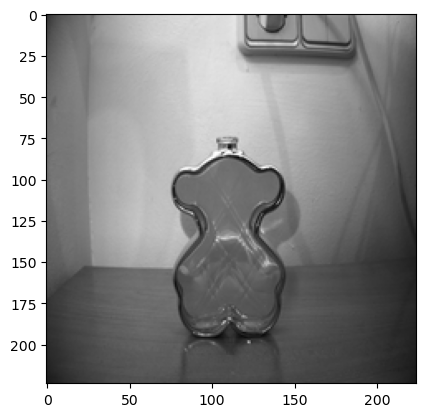

In [37]:
num=random.randint(0,len(positive_file_paths)-1)
check_anomaly(positive_file_paths[num])
print("This image directory is: ", positive_file_paths[num])

From the specific tests above, the model has succesfully discriminated negative samples from the positive ones. However, varifying various images, it was seen that the performance is poor. Next we will label the images so that we can better analyze the results of all of them.

## Trehshold based on Gaussian distribution of the non-anomaly images

Above calculated threshold was computed in a simpler way; every reconstruction error above certain value is considered anomaly image. In this section, a more sophisticated threshold is calculated, one that is based on the Gaussian distribution of the non-anomaly images. 

In [38]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [39]:
def map_error2prob(value):
    # Calculate the mean and standard deviation
    mean = na_average_recon_error
    std_dev = na_stdev_recon_error
    aux_score = value - mean
    prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
    if prob_score<0:
        prob_score = 0
    if prob_score>100:
        prob_score = 100
    return prob_score

See below test, that shows if a reconstruction error is equal to the mean of the reconstruction error plus its standard deviation has 50% chance of being predicted as anomaly image.

In [40]:
print(map_error2prob(na_average_recon_error + na_stdev_recon_error))

50.000000000000036


In [41]:
def map_error2prob_list(input_list):
    # Calculate the mean and standard deviation
    mean = na_average_recon_error
    std_dev = na_stdev_recon_error
    prob_score_list = []
    for i in range (len(input_list)):
        aux_score = input_list[i] - mean
        prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        if prob_score<0:
            prob_score = 0
        if prob_score>100:
            prob_score = 100
        prob_score_list.append(prob_score)
    return prob_score_list

Checking the probability of being detected as anomaly images of the set of non-anomaly images. Ideally, all these images should output a probability of around 0%, because these are not anomaly images.

In [42]:
print("Considering the non-anomaly dataset. The number of images to be cheked is: ", len(total_rec_error_list))
preds_probs = np.array(map_error2prob_list(total_rec_error_list))
preds_probs = preds_probs/100
print("The prediction probabilities list for the non-anomaly images is: ")
print(preds_probs)

Considering the non-anomaly dataset. The number of images to be cheked is:  179
The prediction probabilities list for the non-anomaly images is: 
[2.69012444e-01 2.57066005e-01 2.34814082e-01 2.49499337e-01
 1.00000000e+00 5.89114581e-01 5.29363062e-01 1.05227388e-01
 2.31223789e-01 4.35520011e-01 1.69360689e-01 2.76335666e-02
 3.60746008e-02 2.06407430e-01 8.70400659e-02 2.88788845e-01
 4.82833529e-01 9.68003237e-03 1.23173957e-02 1.97428137e-02
 2.69042638e-01 1.22344282e-01 7.04324466e-02 2.10196602e-01
 3.80250781e-01 1.18700848e-01 4.57879828e-01 4.03806834e-01
 3.71272173e-01 4.45301928e-01 2.39123802e-01 2.58616377e-01
 2.29492655e-01 2.08896582e-01 1.28498667e-01 2.35853568e-01
 2.08456552e-01 5.40794330e-01 5.30159125e-01 5.29287921e-01
 3.92154084e-01 4.23772854e-01 4.21644565e-01 4.32944244e-01
 4.12572011e-01 3.15041098e-01 3.12692995e-01 2.29482187e-01
 4.27606915e-01 5.01547698e-01 5.10663933e-01 5.52925154e-01
 5.32249973e-01 5.02188217e-01 5.79571140e-01 1.13693843e-01


# Evaluating the performance of the model

In [43]:
def computePred(err_value):
    pred = 0
    prob_anomaly = map_error2prob(err_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    return pred

Saving the labels of the evaluation set

In [44]:
labels_test = test_set_generator.labels

In [45]:
print(labels_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]


Displaying all the images in the test set

In [46]:

fig, axes = plt.subplots(nrows=6, ncols=5, sharex=True, sharey=True, figsize=(300,200))
index = 0
for i in range(len(test_set_generator)):        # Traversing all the batches of the test set
    images_in_batch = next(test_set_generator)[0]
    for i in range(images_in_batch.shape[0]):        #I think this should be the correct while clause
        single_img = images_in_batch[i]
        ax = fig.add_subplot(6, 5, index+1, xticks=[], yticks=[])
        index = index+1
        plt.imshow(single_img)
plt.show()


Testing a nested for loop that traverses all the images in the test set. It is expected that the list of numbers go until 14, twice.

In [47]:
for i in range(len(test_set_generator)):        
    batch_images = next(test_set_generator)[0]
    for im in range(0, batch_images.shape[0]):
        print(im)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Computing the prediction for each image of the test set and printing it next to the groudn truth labels list.

In [48]:
y_pred_final = []
y_true_final = []

errors_list = []
for i in range(len(test_set_generator)):        # Traversing all the batches of the test set
    batch_images = next(test_set_generator)[0]
    y_pred = []
    y_true = []
    if(i>0):
        index = batch_images.shape[0]*i
    else:
        index = 0
        
    for im in range(0, batch_images.shape[0]):  #Traversing all the images in the batch
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]])[0]
        errors_list.append(reconstruction_error)
        prediction = computePred(reconstruction_error)   
        y_pred.append(prediction) # Save Prediction
        y_true.append(labels_test[index]) # Save Truth 
        index = index+1

    y_pred_final.append(y_pred)  
    y_true_final.append(y_true)  
print(y_true_final)
print(y_pred_final)

1/1 [==============================] - 0s 45ms/step - loss: 0.0037 - mean_squared_error: 0.0037
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [49]:
print(errors_list) 

[0.001292878296226263, 0.0013493801234290004, 0.001343156211078167, 0.0013288580812513828, 0.0013496526516973972, 0.0013592796167358756, 0.001437402213923633, 0.0013363971374928951, 0.0013344591716304421, 0.0013535734033212066, 0.001303649041801691, 0.0012987274676561356, 0.0012860724236816168, 0.0012631246354430914, 0.0013217482483014464, 0.0012998741585761309, 0.0016192228067666292, 0.00148017646279186, 0.0013721183640882373, 0.0013789489166811109, 0.0013546542031690478, 0.0013424803037196398, 0.0013343594036996365, 0.0013453519204631448, 0.0013740232679992914, 0.003656763816252351, 0.003619820112362504, 0.0036433956120163202, 0.0035998665262013674, 0.0036697497125715017]


In [50]:
print(len(errors_list))

30


In [51]:
na_average_recon_error - na_stdev_recon_error

0.0009036083190055785

In [52]:
na_average_recon_error + na_stdev_recon_error

0.0011927746815727574

In [53]:
y_true_final = [item for sublist in y_true_final for item in sublist]
y_pred_final = [item for sublist in y_pred_final for item in sublist]
print(y_true_final)
print(y_pred_final)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Results shown above are surprisingly shit!!

# Using some metrics for evaluating model predictions

In [54]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity
from sklearn.metrics import f1_score

### The Precision metric

Precision = True positives / (True positives + False positives).

Answers the question: Which proportion of positive predictions is actually right?

In [55]:
pre = Precision()

In [56]:
pre.reset_state()
pre.update_state(y_true_final, y_pred_final)
pre.result().numpy()

0.16666667

### The Recall metric

Recall = TruePositives / (TruePositives + FalseNegatives)

This metric is also called "sensitiviy" and TPR "True Positive Rate". It responds how good is the model at catching YESes?

In [57]:
re = Recall()

In [58]:
re.reset_state()
re.update_state(y_true_final, y_pred_final)
re.result().numpy()

1.0

### The Specificity metric

The specificity metric is the opposite as sensitivity, it tells us how good is the model at catching NOes. It measures the proportion of actual negatives that are correctly identified as such.

Specificity = (tn / (tn + fp))

As we are working in here with full NOes, that is bottles WITHOUT anomalies, perhaps this would be a good metric for this case.

In [59]:
from sklearn.metrics import confusion_matrix
import math


In [60]:
tn, fp, fn, tp = confusion_matrix(y_true_final, y_pred_final).ravel()
specificity_val = tn/(tn+fp)
if(math.isnan(specificity_val)):
    specificity_val = 0
print("The specificity value is: ", specificity_val)

The specificity value is:  0.0


### The Accuracy metric

Accuracy = (True negatives + True positives) / (True positives + True negatives + False positives + False negatives)

In [61]:
acc = BinaryAccuracy()

In [62]:
acc.reset_state()
acc.update_state(y_true_final, y_pred_final)
acc.result().numpy()

0.16666667

### The Confusion Matrix

Having the predicted and true labels we can generate the confustion matrix. 

In [63]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [64]:
conf_matrix = confusion_matrix(y_true_final, y_pred_final)
print(conf_matrix)

[[ 0 25]
 [ 0  5]]


Text(0.5, 23.52222222222222, 'Predicted label')

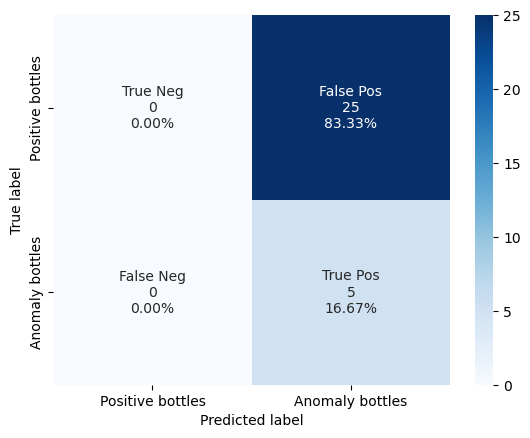

In [65]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(conf_matrix, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [66]:
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]

Additionally we can compute the TPR:

In [67]:
_tpr = _tp/(_tp+_fn)
print("The TPR values are: ", _tpr)

The TPR values are:  1.0


And the FPR:

In [68]:
_fpr = _fp / (_tn + _fp)
print("The FPR value is: ", _fpr)

The FPR value is:  1.0


### The ROC curve

In [69]:
from sklearn.metrics import roc_curve, roc_auc_score

In [70]:
rec_error_test_set_final = []
for i in range(len(test_set_generator)):        #I think this should be the correct while clause
    batch_images = next(test_set_generator)[0]
    rec_error_test_set = []
    for im in range(0, batch_images.shape[0]):
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]])[0]
          
        rec_error_test_set.append(reconstruction_error) # Save Prediction
    rec_error_test_set_final.append(rec_error_test_set)  
print(rec_error_test_set_final)

1/1 [==============================] - 0s 64ms/step - loss: 0.0037 - mean_squared_error: 0.0037
[[0.001292878296226263, 0.0013493801234290004, 0.001343156211078167, 0.0013288580812513828, 0.0013496526516973972, 0.0013592796167358756, 0.001437402213923633, 0.0013363971374928951, 0.0013344591716304421, 0.0013535734033212066, 0.001303649041801691, 0.0012987274676561356, 0.0012860724236816168, 0.0012631246354430914, 0.0013217482483014464], [0.0012998741585761309, 0.0016192228067666292, 0.00148017646279186, 0.0013721183640882373, 0.0013789489166811109, 0.0013546542031690478, 0.0013424803037196398, 0.0013343594036996365, 0.0013453519204631448, 0.0013740232679992914, 0.003656763816252351, 0.003619820112362504, 0.0036433956120163202, 0.0035998665262013674, 0.0036697497125715017]]


In [71]:
rec_error_test_set_final = [item for sublist in rec_error_test_set_final for item in sublist]
print(rec_error_test_set_final)

[0.001292878296226263, 0.0013493801234290004, 0.001343156211078167, 0.0013288580812513828, 0.0013496526516973972, 0.0013592796167358756, 0.001437402213923633, 0.0013363971374928951, 0.0013344591716304421, 0.0013535734033212066, 0.001303649041801691, 0.0012987274676561356, 0.0012860724236816168, 0.0012631246354430914, 0.0013217482483014464, 0.0012998741585761309, 0.0016192228067666292, 0.00148017646279186, 0.0013721183640882373, 0.0013789489166811109, 0.0013546542031690478, 0.0013424803037196398, 0.0013343594036996365, 0.0013453519204631448, 0.0013740232679992914, 0.003656763816252351, 0.003619820112362504, 0.0036433956120163202, 0.0035998665262013674, 0.0036697497125715017]


In [72]:
y_prob = map_error2prob_list(rec_error_test_set_final)
print(y_prob)

[84.61800112737863, 100, 100, 97.06059116644688, 100, 100, 100, 99.66776033183031, 98.99756970341558, 100, 88.34275855760212, 86.64077147242996, 82.26438278663365, 74.32853989163088, 94.60185672485545, 87.03732206352055, 100, 100, 100, 100, 100, 100, 98.96306778904352, 100, 100, 100, 100, 100, 100, 100]


In [73]:
auc_score = roc_auc_score(y_true_final, y_prob)
print('AUROC = %.3f' % (auc_score))
fpr, tpr, thresholds = roc_curve(y_true_final, y_prob)
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

AUROC = 0.720
The fpr is:  [0.   0.56 1.  ]
The tpr is:  [0. 1. 1.]
The thresholds are:  [101.         100.          74.32853989]


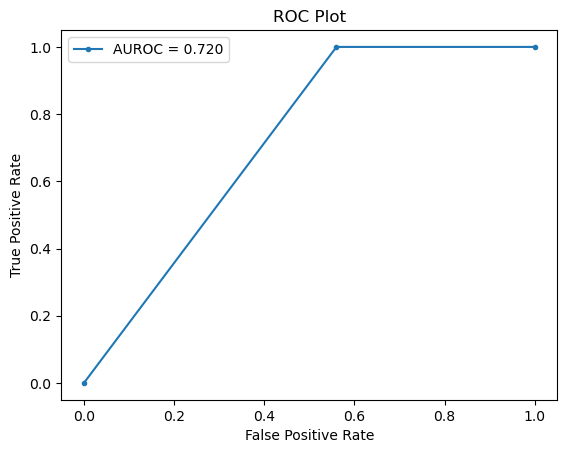

In [74]:
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % auc_score)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

Above we can see that the results are quite poor.

## Testing the results of the roc_curve function

According to the above, with a threshold of 0.17489895 we will have:
- TPR = 1
- FPR = 0

This is for the UBUNTU laptop


According to the above, with a threshold of 0.17489895 we will have:
- TPR = 1.0
- FPR = 1.0

This is for the work laptop


We already have:
- TPR = 1
- FPR = 0.08

With a threshodl of 0.5. So let's validate if with 0.17489895 we obtain what is expected

This is for the UBUNTU laptop

In [75]:
def computePred_v2(err_value):
    pred = 0
    prob_anomaly = map_error2prob(err_value)/100
    if prob_anomaly > 0.74328539:
        pred = 1
    return pred

In [76]:
y_pred_final = []
y_true_final = []

errors_list = []
for i in range(len(test_set_generator)):        # Traversing all the batches of the test set
    batch_images = next(test_set_generator)[0]
    y_pred = []
    y_true = []
    if(i>0):
        index = batch_images.shape[0]*i
    else:
        index = 0
        
    for im in range(0, batch_images.shape[0]):  #Traversing all the images in the batch
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]])[0]
        errors_list.append(reconstruction_error)
        prediction = computePred_v2(reconstruction_error)   
        y_pred.append(prediction) # Save Prediction
        y_true.append(labels_test[index]) # Save Truth 
        index = index+1

    y_pred_final.append(y_pred)  
    y_true_final.append(y_true)  
print(y_true_final)
print(y_pred_final)

1/1 [==============================] - 0s 54ms/step - loss: 0.0037 - mean_squared_error: 0.0037
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [77]:
y_true_final = [item for sublist in y_true_final for item in sublist]
y_pred_final = [item for sublist in y_pred_final for item in sublist]
print(y_true_final)
print(y_pred_final)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [78]:
conf_matrix = confusion_matrix(y_true_final, y_pred_final)
print(conf_matrix)

[[ 0 25]
 [ 0  5]]


Text(0.5, 23.52222222222222, 'Predicted label')

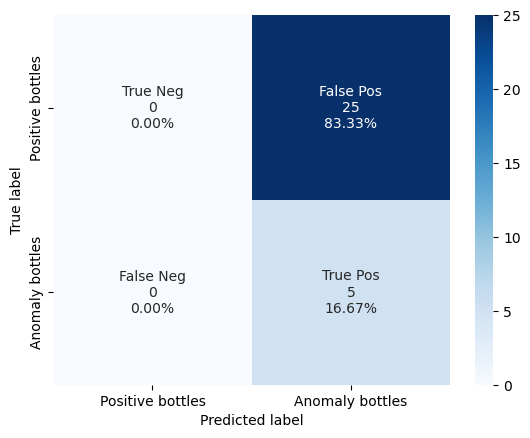

In [79]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(conf_matrix, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [80]:
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
print("The TPR values are: ", _tpr)
_fpr = _fp / (_tn + _fp)
print("The FPR value is: ", _fpr)

The TPR values are:  1.0
The FPR value is:  1.0


But nop, the FPR is even higher than with the trheshold = 50%. We conclude that the ROC curve analysis using the "roc_curve()" function does not work that well when there is only three possible threshold values.